# Proof Of Concept

This notebook aims to apprehend the topic and structure the goal of this project

## Librairies

In [137]:
import pandas as pd
import yfinance as yf
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import functools as ft
import networkx as nx
import numpy as np

import torch
from torch_geometric.data import Data, Batch

## 1. Prepare Data

### Extract

In [14]:
t = yf.Ticker("PETR4.SA")
petr4 = t.history(period="max").reset_index()[["Date", "Close"]]
petr4["Date"] = petr4['Date'].dt.strftime('%Y%m%d')
petr4.columns = ["Date", "petr4_close"]

In [26]:
t = yf.Ticker("BPAC11.SA")
btg = t.history(period="max").reset_index()[["Date", "Close"]]
btg["Date"] = btg['Date'].dt.strftime('%Y%m%d')
btg.columns = ["Date", "btg_close"]

In [27]:
t = yf.Ticker("B3SA3.SA")
b3 = t.history(period="max").reset_index()[["Date", "Close"]]
b3["Date"] = b3['Date'].dt.strftime('%Y%m%d')
b3.columns = ["Date", "b3_close"]

### Join

In [29]:
df = ft.reduce(lambda left, right: pd.merge(left, right, on='Date', how = "inner"), [petr4, btg, b3])

In [62]:
dataset = df.sort_values("Date").drop(columns="Date")

In [77]:
dataset

,petr4_close,btg_close,b3_close
0,5.587599,3.654601,5.058690
1,5.712750,3.604400,5.079965
2,5.561833,3.604400,4.973579
3,5.639132,3.765042,5.000175
4,5.558152,3.855403,4.968258
...,...,...,...
1590,29.100000,32.889999,14.600000
1591,29.129999,33.320000,14.610000
1592,29.680000,34.080002,15.170000
1593,30.299999,33.700001,15.100000


In [80]:
6*1586

9516

## Create dataset

### Training set

In [122]:
# Create a mapping of node names (stocks) to integers
node_mapping = {node: i for i, node in enumerate(dataset.columns)}

edge_indices = []
edge_weights = []
node_features = []
graphs = []
labels = []

k = 10
test_size = 100

for t in tqdm(range(k, len(dataset) - test_size)):
    
    # Step 1: Create correlation matrix and graph for this time step
    correlation_matrix = dataset.iloc[:t].corr()
    graph = nx.from_pandas_adjacency(correlation_matrix)
    graphs.append(graph)

    # Step 2: Convert edges to integer tuples and store as tensor
    edges = list(graph.edges)
    edges_mapped = [(node_mapping[u], node_mapping[v]) for u, v in edges]
    edge_indices.append(torch.tensor(edges_mapped, dtype=torch.long).t().contiguous())

    # Step 3: Store edge weights as tensor
    edge_weights.append(torch.tensor([graph[u][v]['weight'] for u, v in edges], dtype=torch.float))

    # Step 4: Store closing prices as node features (assume last column of df is 'Close')
    node_features.append(torch.tensor(dataset.iloc[t-k:t, :].T.values, dtype=torch.float))
    
    # Step 5: Store prices at t+1 as labels
    labels.append(torch.tensor(dataset.iloc[t, :], dtype=torch.float))

# Combine edge_indices, edge_weights, and node_features into a list of Data objects
data_list = [Data(x=node_features[i], edge_index=edge_indices[i], edge_attr=edge_weights[i], y = labels[i]) for i in range(len(graphs))]

# Convert data_list into a Batch for feeding into your model
batch = Batch.from_data_list(data_list)


100%|██████████| 1485/1485 [00:01<00:00, 796.66it/s]


### Test set

In [142]:
# Create a mapping of node names (stocks) to integers
node_mapping = {node: i for i, node in enumerate(dataset.columns)}

edge_indices = []
edge_weights = []
node_features = []
graphs = []
labels = []

k = 10
test_size = 100

for t in tqdm(range(len(dataset) - test_size, len(dataset))):
    
    # Step 1: Create correlation matrix and graph for this time step
    correlation_matrix = dataset.iloc[:t].corr()
    graph = nx.from_pandas_adjacency(correlation_matrix)
    graphs.append(graph)

    # Step 2: Convert edges to integer tuples and store as tensor
    edges = list(graph.edges)
    edges_mapped = [(node_mapping[u], node_mapping[v]) for u, v in edges]
    edge_indices.append(torch.tensor(edges_mapped, dtype=torch.long).t().contiguous())

    # Step 3: Store edge weights as tensor
    edge_weights.append(torch.tensor([graph[u][v]['weight'] for u, v in edges], dtype=torch.float))

    # Step 4: Store closing prices as node features (assume last column of df is 'Close')
    node_features.append(torch.tensor(dataset.iloc[t-k:t, :].T.values, dtype=torch.float))
    
    # Step 5: Store prices at t+1 as labels
    labels.append(torch.tensor(dataset.iloc[t, :], dtype=torch.float))

# Combine edge_indices, edge_weights, and node_features into a list of Data objects
data_list_test = [Data(x=node_features[i], edge_index=edge_indices[i], edge_attr=edge_weights[i], y = labels[i]) for i in range(len(graphs))]

# Convert data_list into a Batch for feeding into your model
batch_test = Batch.from_data_list(data_list_test)


100%|██████████| 100/100 [00:00<00:00, 518.17it/s]


## Model 

In [123]:
import torch.nn.functional as F
from torch_geometric.nn import GraphConv
from torch.optim import Adam

class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(num_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        return x


## Training

In [127]:
# Assuming node features are 3 and we want to predict next price (1 value)
model = GNN(num_features=10, hidden_channels=6, num_classes=1)

In [136]:

# Define a suitable optimizer
optimizer = Adam(model.parameters(), lr=0.01)

# Define loss function - mean squared error loss
loss_func = torch.nn.MSELoss()

# Number of epochs
epochs = 100

In [138]:
# Training loop
for epoch in range(epochs):
    loss_list = []
    print("EPOCH > ", epoch)
    for data in tqdm(batch.to_data_list()): # Iterate over each graph in the batch
        model.train()
        optimizer.zero_grad()

        #print("data: ", data)
        # Forward pass
        out = model(data).squeeze()
        
        #print("out: ", out)

        # Calculate loss
        loss = loss_func(out, data.y)
        loss_list.append(loss.item())
        
        
        # Backward pass
        loss.backward()
        optimizer.step()

        model.eval()
    print("Mean Loss: ", np.mean(loss_list))


EPOCH >  0


100%|██████████| 1485/1485 [00:01<00:00, 923.46it/s]


Mean Loss:  0.5580933461223669
EPOCH >  1


100%|██████████| 1485/1485 [00:01<00:00, 962.38it/s]


Mean Loss:  0.6621371364200594
EPOCH >  2


100%|██████████| 1485/1485 [00:01<00:00, 934.85it/s]


Mean Loss:  0.6781841807949917
EPOCH >  3


Exception ignored in: <function tqdm.__del__ at 0x7fbc68c71b80>
Traceback (most recent call last):
  File "/Users/valentincthrn/Desktop/TCC/StockMarketGNN/tcc-env/lib/python3.9/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/valentincthrn/Desktop/TCC/StockMarketGNN/tcc-env/lib/python3.9/site-packages/tqdm/std.py", line 1274, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'
100%|██████████| 1485/1485 [00:01<00:00, 870.38it/s]


Mean Loss:  0.6685013406136839
EPOCH >  4


100%|██████████| 1485/1485 [00:01<00:00, 1001.17it/s]


Mean Loss:  0.6457351271678483
EPOCH >  5


100%|██████████| 1485/1485 [00:01<00:00, 996.33it/s] 


Mean Loss:  0.6176038777944867
EPOCH >  6


100%|██████████| 1485/1485 [00:01<00:00, 992.87it/s] 


Mean Loss:  0.5901461353745807
EPOCH >  7


100%|██████████| 1485/1485 [00:01<00:00, 1007.59it/s]


Mean Loss:  0.5673064886335196
EPOCH >  8


100%|██████████| 1485/1485 [00:01<00:00, 1021.47it/s]


Mean Loss:  0.5507615716135449
EPOCH >  9


100%|██████████| 1485/1485 [00:01<00:00, 977.57it/s] 


Mean Loss:  0.5403399040782981
EPOCH >  10


100%|██████████| 1485/1485 [00:01<00:00, 960.61it/s] 


Mean Loss:  0.5347216278960558
EPOCH >  11


100%|██████████| 1485/1485 [00:01<00:00, 910.77it/s]


Mean Loss:  0.5320766039492142
EPOCH >  12


100%|██████████| 1485/1485 [00:01<00:00, 983.97it/s]


Mean Loss:  0.5306052922526757
EPOCH >  13


100%|██████████| 1485/1485 [00:01<00:00, 955.20it/s] 


Mean Loss:  0.5290940075408768
EPOCH >  14


100%|██████████| 1485/1485 [00:01<00:00, 894.84it/s]


Mean Loss:  0.5273963986017964
EPOCH >  15


100%|██████████| 1485/1485 [00:01<00:00, 1008.32it/s]


Mean Loss:  0.5272196786565964
EPOCH >  16


100%|██████████| 1485/1485 [00:01<00:00, 1019.73it/s]


Mean Loss:  0.5285019416824572
EPOCH >  17


100%|██████████| 1485/1485 [00:01<00:00, 994.36it/s] 


Mean Loss:  0.5302796024070294
EPOCH >  18


100%|██████████| 1485/1485 [00:01<00:00, 949.43it/s] 


Mean Loss:  0.5307685818713667
EPOCH >  19


100%|██████████| 1485/1485 [00:01<00:00, 887.89it/s]


Mean Loss:  0.529847535028229
EPOCH >  20


100%|██████████| 1485/1485 [00:01<00:00, 994.17it/s] 


Mean Loss:  0.5271641266272366
EPOCH >  21


100%|██████████| 1485/1485 [00:01<00:00, 904.01it/s] 


Mean Loss:  0.5241832292673605
EPOCH >  22


100%|██████████| 1485/1485 [00:01<00:00, 994.37it/s] 


Mean Loss:  0.521129776627846
EPOCH >  23


100%|██████████| 1485/1485 [00:01<00:00, 971.21it/s]


Mean Loss:  0.5180684596676417
EPOCH >  24


100%|██████████| 1485/1485 [00:01<00:00, 936.18it/s]


Mean Loss:  0.5149148160547037
EPOCH >  25


100%|██████████| 1485/1485 [00:01<00:00, 818.22it/s]


Mean Loss:  0.5118988252765427
EPOCH >  26


100%|██████████| 1485/1485 [00:01<00:00, 921.64it/s] 


Mean Loss:  0.5089516898200875
EPOCH >  27


100%|██████████| 1485/1485 [00:01<00:00, 993.88it/s] 


Mean Loss:  0.5063531745657927
EPOCH >  28


100%|██████████| 1485/1485 [00:01<00:00, 988.14it/s] 


Mean Loss:  0.5039816217713359
EPOCH >  29


100%|██████████| 1485/1485 [00:01<00:00, 950.91it/s]


Mean Loss:  0.5019007258455862
EPOCH >  30


100%|██████████| 1485/1485 [00:01<00:00, 876.27it/s]


Mean Loss:  0.5001055624177648
EPOCH >  31


100%|██████████| 1485/1485 [00:01<00:00, 916.34it/s]


Mean Loss:  0.4984600688609128
EPOCH >  32


100%|██████████| 1485/1485 [00:01<00:00, 936.72it/s]


Mean Loss:  0.4971509464916864
EPOCH >  33


100%|██████████| 1485/1485 [00:01<00:00, 986.30it/s] 


Mean Loss:  0.4959712219960762
EPOCH >  34


100%|██████████| 1485/1485 [00:01<00:00, 977.89it/s] 


Mean Loss:  0.4950434597244373
EPOCH >  35


100%|██████████| 1485/1485 [00:01<00:00, 969.83it/s]


Mean Loss:  0.49430088944347444
EPOCH >  36


100%|██████████| 1485/1485 [00:01<00:00, 968.87it/s]


Mean Loss:  0.49365378041431834
EPOCH >  37


100%|██████████| 1485/1485 [00:01<00:00, 914.40it/s]


Mean Loss:  0.4931311352416773
EPOCH >  38


100%|██████████| 1485/1485 [00:01<00:00, 861.53it/s]


Mean Loss:  0.49307778263135316
EPOCH >  39


100%|██████████| 1485/1485 [00:01<00:00, 990.71it/s] 


Mean Loss:  0.4926799824085049
EPOCH >  40


100%|██████████| 1485/1485 [00:01<00:00, 963.63it/s] 


Mean Loss:  0.4924526194323745
EPOCH >  41


100%|██████████| 1485/1485 [00:01<00:00, 973.34it/s]


Mean Loss:  0.4922372517868977
EPOCH >  42


100%|██████████| 1485/1485 [00:01<00:00, 1004.73it/s]


Mean Loss:  0.492047608386559
EPOCH >  43


100%|██████████| 1485/1485 [00:01<00:00, 1002.82it/s]


Mean Loss:  0.4922050231958736
EPOCH >  44


100%|██████████| 1485/1485 [00:01<00:00, 993.35it/s] 


Mean Loss:  0.4920550942427231
EPOCH >  45


100%|██████████| 1485/1485 [00:01<00:00, 1026.40it/s]


Mean Loss:  0.49191582564865033
EPOCH >  46


100%|██████████| 1485/1485 [00:01<00:00, 956.80it/s] 


Mean Loss:  0.4918227027636021
EPOCH >  47


100%|██████████| 1485/1485 [00:01<00:00, 940.13it/s] 


Mean Loss:  0.49169906972615857
EPOCH >  48


100%|██████████| 1485/1485 [00:01<00:00, 1005.04it/s]


Mean Loss:  0.49197176936786524
EPOCH >  49


100%|██████████| 1485/1485 [00:01<00:00, 1007.89it/s]


Mean Loss:  0.49179638487064226
EPOCH >  50


100%|██████████| 1485/1485 [00:01<00:00, 1005.95it/s]


Mean Loss:  0.4917012371888748
EPOCH >  51


100%|██████████| 1485/1485 [00:01<00:00, 981.13it/s] 


Mean Loss:  0.49193529923107815
EPOCH >  52


100%|██████████| 1485/1485 [00:01<00:00, 908.77it/s] 


Mean Loss:  0.4918150952295165
EPOCH >  53


100%|██████████| 1485/1485 [00:01<00:00, 841.01it/s]


Mean Loss:  0.4917091900613692
EPOCH >  54


100%|██████████| 1485/1485 [00:01<00:00, 843.59it/s]


Mean Loss:  0.49197380789438017
EPOCH >  55


100%|██████████| 1485/1485 [00:01<00:00, 986.56it/s] 


Mean Loss:  0.491861323927849
EPOCH >  56


100%|██████████| 1485/1485 [00:01<00:00, 775.47it/s]


Mean Loss:  0.4917615797322852
EPOCH >  57


100%|██████████| 1485/1485 [00:01<00:00, 1029.66it/s]


Mean Loss:  0.4920474991034591
EPOCH >  58


100%|██████████| 1485/1485 [00:01<00:00, 745.86it/s]


Mean Loss:  0.49188840800844547
EPOCH >  59


100%|██████████| 1485/1485 [00:01<00:00, 847.68it/s]


Mean Loss:  0.4917759966252604
EPOCH >  60


100%|██████████| 1485/1485 [00:01<00:00, 959.35it/s] 


Mean Loss:  0.4920766189197386
EPOCH >  61


100%|██████████| 1485/1485 [00:01<00:00, 753.65it/s]


Mean Loss:  0.49193142870392476
EPOCH >  62


100%|██████████| 1485/1485 [00:01<00:00, 778.87it/s]


Mean Loss:  0.4922175204551462
EPOCH >  63


100%|██████████| 1485/1485 [00:01<00:00, 864.68it/s]


Mean Loss:  0.49212474644463194
EPOCH >  64


100%|██████████| 1485/1485 [00:01<00:00, 832.72it/s]


Mean Loss:  0.4920624034951977
EPOCH >  65


100%|██████████| 1485/1485 [00:01<00:00, 1024.12it/s]


Mean Loss:  0.4923539528468003
EPOCH >  66


100%|██████████| 1485/1485 [00:01<00:00, 1075.43it/s]


Mean Loss:  0.49226859220748875
EPOCH >  67


100%|██████████| 1485/1485 [00:01<00:00, 1066.93it/s]


Mean Loss:  0.49220580683577403
EPOCH >  68


100%|██████████| 1485/1485 [00:01<00:00, 1015.06it/s]


Mean Loss:  0.4924914082400156
EPOCH >  69


100%|██████████| 1485/1485 [00:01<00:00, 1002.63it/s]


Mean Loss:  0.49244219103266773
EPOCH >  70


100%|██████████| 1485/1485 [00:01<00:00, 883.82it/s]


Mean Loss:  0.4926566725000206
EPOCH >  71


100%|██████████| 1485/1485 [00:01<00:00, 1019.63it/s]


Mean Loss:  0.49252940404435824
EPOCH >  72


100%|██████████| 1485/1485 [00:01<00:00, 1029.88it/s]


Mean Loss:  0.49280053110917094
EPOCH >  73


100%|██████████| 1485/1485 [00:01<00:00, 1003.48it/s]


Mean Loss:  0.49269201902802784
EPOCH >  74


100%|██████████| 1485/1485 [00:01<00:00, 1025.25it/s]


Mean Loss:  0.49296509534699107
EPOCH >  75


100%|██████████| 1485/1485 [00:01<00:00, 1010.24it/s]


Mean Loss:  0.49287321866256334
EPOCH >  76


100%|██████████| 1485/1485 [00:01<00:00, 1035.19it/s]


Mean Loss:  0.4928146103636898
EPOCH >  77


100%|██████████| 1485/1485 [00:01<00:00, 1045.61it/s]


Mean Loss:  0.49309406245397
EPOCH >  78


100%|██████████| 1485/1485 [00:01<00:00, 1037.28it/s]


Mean Loss:  0.4929993911116362
EPOCH >  79


100%|██████████| 1485/1485 [00:01<00:00, 1038.93it/s]


Mean Loss:  0.49293764069533724
EPOCH >  80


100%|██████████| 1485/1485 [00:01<00:00, 1019.79it/s]


Mean Loss:  0.49321225180685746
EPOCH >  81


100%|██████████| 1485/1485 [00:01<00:00, 1021.34it/s]


Mean Loss:  0.49311418893499304
EPOCH >  82


100%|██████████| 1485/1485 [00:01<00:00, 1075.12it/s]


Mean Loss:  0.493054223799316
EPOCH >  83


100%|██████████| 1485/1485 [00:01<00:00, 1030.76it/s]


Mean Loss:  0.493330478278202
EPOCH >  84


100%|██████████| 1485/1485 [00:01<00:00, 1069.60it/s]


Mean Loss:  0.4932361534923654
EPOCH >  85


100%|██████████| 1485/1485 [00:01<00:00, 1062.02it/s]


Mean Loss:  0.4931968876042306
EPOCH >  86


100%|██████████| 1485/1485 [00:01<00:00, 1060.37it/s]


Mean Loss:  0.49316326102691854
EPOCH >  87


100%|██████████| 1485/1485 [00:01<00:00, 1024.06it/s]


Mean Loss:  0.4934528025186241
EPOCH >  88


100%|██████████| 1485/1485 [00:01<00:00, 900.10it/s]


Mean Loss:  0.49336966869871285
EPOCH >  89


100%|██████████| 1485/1485 [00:01<00:00, 923.31it/s]


Mean Loss:  0.4933400397987798
EPOCH >  90


100%|██████████| 1485/1485 [00:01<00:00, 1016.94it/s]


Mean Loss:  0.49331878350470654
EPOCH >  91


100%|██████████| 1485/1485 [00:01<00:00, 1009.85it/s]


Mean Loss:  0.4936193581180559
EPOCH >  92


100%|██████████| 1485/1485 [00:01<00:00, 920.02it/s]


Mean Loss:  0.49354446523341505
EPOCH >  93


100%|██████████| 1485/1485 [00:01<00:00, 935.50it/s]


Mean Loss:  0.49352301520049285
EPOCH >  94


100%|██████████| 1485/1485 [00:01<00:00, 828.22it/s]


Mean Loss:  0.4935195088808296
EPOCH >  95


100%|██████████| 1485/1485 [00:01<00:00, 857.28it/s]


Mean Loss:  0.4936009445070894
EPOCH >  96


100%|██████████| 1485/1485 [00:01<00:00, 1010.66it/s]


Mean Loss:  0.4937760140326639
EPOCH >  97


100%|██████████| 1485/1485 [00:01<00:00, 934.47it/s]


Mean Loss:  0.49384914197722257
EPOCH >  98


100%|██████████| 1485/1485 [00:01<00:00, 824.91it/s]


Mean Loss:  0.49377981824980677
EPOCH >  99


100%|██████████| 1485/1485 [00:01<00:00, 935.59it/s] 

Mean Loss:  0.4940819965024802


### Testing

In [143]:
N = len(dataset)
testset = dataset.iloc[N-test_size:, :]

In [144]:
testset

,petr4_close,btg_close,b3_close
1495,21.133572,19.440001,10.355125
1496,20.582260,19.379999,10.443884
1497,21.467701,19.320000,10.374849
1498,21.684881,19.780001,10.808779
1499,20.966507,19.410000,10.897537
...,...,...,...
1590,29.100000,32.889999,14.600000
1591,29.129999,33.320000,14.610000
1592,29.680000,34.080002,15.170000
1593,30.299999,33.700001,15.100000


In [229]:
preds = []
for i, data in tqdm(enumerate(batch_test.to_data_list())): # Iterate over each graph in the batch

    out = list(model(data).detach().numpy())
    
    preds.append(out)

df_pred = pd.DataFrame(np.squeeze(np.array(preds)), columns = ["petr4_pred_gnn", "btg_pred_gnn", "b3_pred_gnn"])

100it [00:00, 2091.06it/s]

## Result

In [230]:
df_final = pd.concat([df.iloc[-100:, 0].reset_index().drop(columns="index"), testset.reset_index().drop(columns="index"), df_pred], axis=1)

In [231]:
df_final

,Date,petr4_close,btg_close,b3_close,petr4_pred_gnn,btg_pred_gnn,b3_pred_gnn
0,20230301,21.133572,19.440001,10.355125,21.063160,20.158154,10.508205
1,20230302,20.582260,19.379999,10.443884,21.146984,19.489632,10.259307
2,20230303,21.467701,19.320000,10.374849,20.741812,19.889858,10.720746
3,20230306,21.684881,19.780001,10.808779,21.510771,19.915897,10.636232
4,20230307,20.966507,19.410000,10.897537,21.447708,19.813118,10.491675
...,...,...,...,...,...,...,...
95,20230719,29.100000,32.889999,14.600000,28.291529,31.161329,12.190410
96,20230720,29.129999,33.320000,14.610000,28.350166,30.305115,11.547741
97,20230721,29.680000,34.080002,15.170000,28.294792,30.987820,11.910377
98,20230724,30.299999,33.700001,15.100000,28.715916,31.234097,11.899999


In [252]:
col = "b3"
true_col = col + "_close"
pred_gnn_col = col + "_pred_gnn"
pred_naive_col = col + "_pred_naive"
date_col = "Date"

res_pred = df_final[[date_col, true_col, pred_gnn_col]]

# Add naive baseline
res_pred[pred_naive_col] = res_pred[true_col].shift(1)

/var/folders/xk/602tgmp162ngdgy2l3rwdpn00000gn/T/ipykernel_29839/2147176583.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_pred[pred_naive_col] = res_pred[true_col].shift(1)


In [272]:
df_all = df[[date_col, true_col]].merge(res_pred[[date_col, pred_gnn_col, pred_naive_col]], on=date_col, how="left")

In [273]:
df_all

,Date,b3_close,b3_pred_gnn,b3_pred_naive
0,20170224,5.058690,NaN,NaN
1,20170301,5.079965,NaN,NaN
2,20170302,4.973579,NaN,NaN
3,20170303,5.000175,NaN,NaN
4,20170306,4.968258,NaN,NaN
...,...,...,...,...
1590,20230719,14.600000,12.190410,14.71
1591,20230720,14.610000,11.547741,14.60
1592,20230721,15.170000,11.910377,14.61
1593,20230724,15.100000,11.899999,15.17


<Axes: xlabel='Date'>

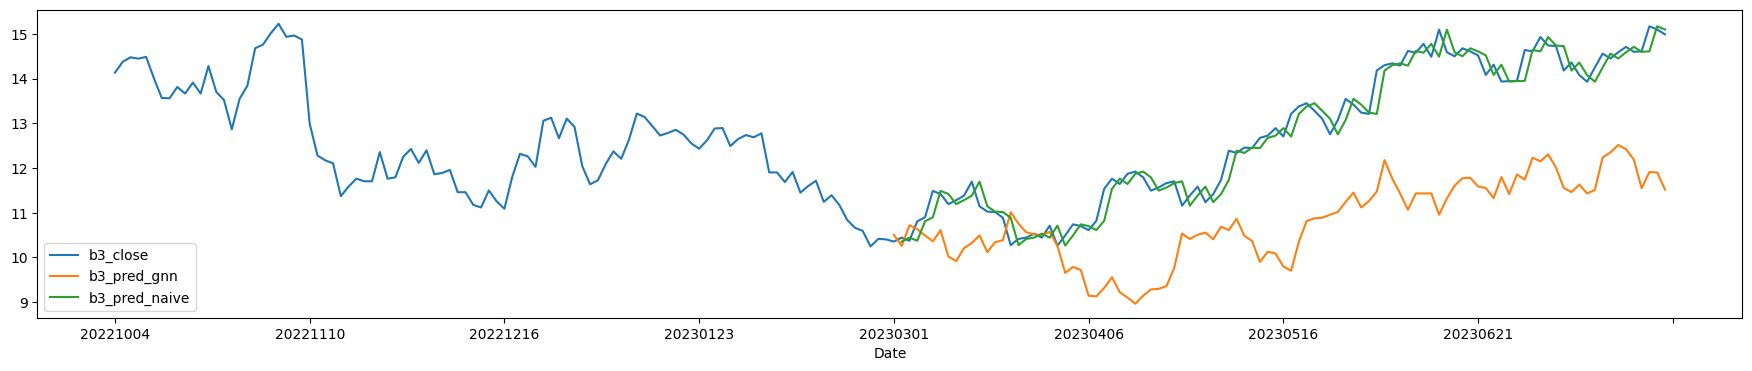

In [275]:
# Overlay the predicted data
df_all.iloc[-200:,:].set_index("Date").plot(figsize=(22,4))

In [276]:
rmse_gnn = ((res_pred[pred_gnn_col] - res_pred[true_col]) ** 2).mean() ** .5
rmse_gnn

2.2129010144177212

In [277]:
rmse_naive = ((res_pred[pred_naive_col] - res_pred[true_col]) ** 2).mean() ** .5
rmse_naive

0.29491942809793303